<a href="https://colab.research.google.com/github/Dhruv-A/instagram_emotion_tagger/blob/emotion_tracker/emotion_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-plot

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
!unzip fer2013_cleaned.zip

In [3]:
!mkdir dataset
!mv 'Angry/' 'dataset/angry'
!mv 'Happy/' 'dataset/happy'
!mv 'Neutral/' 'dataset/neutral'
!mv 'disgust/' 'dataset/disgust'
!mv 'fear/' 'dataset/fear'

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory('dataset', batch_size=32, image_size=(224, 224))
dataset.class_names

Found 16876 files belonging to 5 classes.


['angry', 'disgust', 'fear', 'happy', 'neutral']

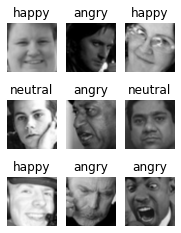

In [15]:
plt.figure(figsize=(3,4))
class_names = dataset.class_names
for images, labels in dataset.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [16]:
# 528 in total
# 422 in training (80%)
# 53 in validation (10%)
# 53 in test (10%)

test_dataset = dataset.skip(422)
train_dataset = dataset.take(422)

validation_dataset = test_dataset.skip(53)
test_dataset = test_dataset.take(53)

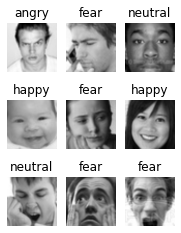

In [20]:
images, labels = train_dataset.as_numpy_iterator().next()

plt.figure(figsize=(3, 4))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(images[i].astype("uint8"))
  plt.title(class_names[labels[i]])
  plt.axis("off")

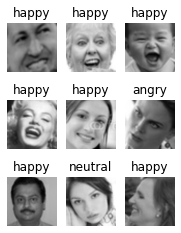

In [21]:
images, labels = validation_dataset.as_numpy_iterator().next()

plt.figure(figsize=(3, 4))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(images[i].astype("uint8"))
  plt.title(class_names[labels[i]])
  plt.axis("off")

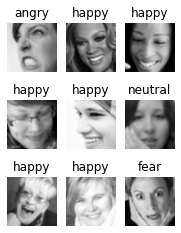

In [22]:
images, labels = test_dataset.as_numpy_iterator().next()

plt.figure(figsize=(3, 4))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(images[i].astype("uint8"))
  plt.title(class_names[labels[i]])
  plt.axis("off")

In [23]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [24]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [25]:
preprocess_input = tf.keras.applications.resnet.preprocess_input

IMG_SHAPE = (224, 224) + (3,)
base_model = tf.keras.applications.MobileNetV3Small(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

4334752/4334752 [==============================] - 0s 0us/step


In [26]:
base_model.trainable = False
base_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

In [34]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
norm_layer_1 = tf.keras.layers.BatchNormalization()
norm_layer_2 = tf.keras.layers.BatchNormalization()
norm_layer_3 = tf.keras.layers.BatchNormalization()
norm_layer_4 = tf.keras.layers.BatchNormalization()
prediction_layer_1 = tf.keras.layers.Dense(512, activation='relu')
prediction_layer_2 = tf.keras.layers.Dense(256, activation='relu')
prediction_layer_3 = tf.keras.layers.Dense(128, activation='relu')
prediction_layer_4 = tf.keras.layers.Dense(32, activation='relu')
prediction_layer_5 = tf.keras.layers.Dense(5, activation='softmax')

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(inputs)
x = global_average_layer(x)
x = prediction_layer_1(x)
x = norm_layer_1(x)
x = prediction_layer_2(x)
x = norm_layer_2(x)
x = prediction_layer_3(x)
x = norm_layer_3(x)
x = prediction_layer_4(x)
x = norm_layer_4(x)
x = prediction_layer_5(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = x

model = tf.keras.Model(inputs, outputs)

In [35]:
from tensorflow.python.training.saver import metrics
model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

In [36]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d_2   (None, 576)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 512)               295424    
                                                                 
 batch_normalization_8 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                           

In [37]:
hist = model.fit(train_dataset, validation_data=validation_dataset, batch_size=32, epochs=20)

Epoch 1/40
422/422 [==============================] - 35s 73ms/step - loss: 5.7552 - accuracy: 0.3609 - val_loss: 4.1293 - val_accuracy: 0.5215
Epoch 2/40
422/422 [==============================] - 30s 71ms/step - loss: 4.8407 - accuracy: 0.4040 - val_loss: 4.6677 - val_accuracy: 0.5668
Epoch 3/40
422/422 [==============================] - 30s 71ms/step - loss: 4.6472 - accuracy: 0.4101 - val_loss: 4.7125 - val_accuracy: 0.5609
Epoch 4/40
422/422 [==============================] - 30s 71ms/step - loss: 4.5383 - accuracy: 0.4120 - val_loss: 4.8968 - val_accuracy: 0.5746
Epoch 5/40
422/422 [==============================] - 31s 73ms/step - loss: 4.4422 - accuracy: 0.4237 - val_loss: 5.1507 - val_accuracy: 0.5728
Epoch 6/40
422/422 [==============================] - 30s 70ms/step - loss: 4.3570 - accuracy: 0.4197 - val_loss: 4.9481 - val_accuracy: 0.5871
Epoch 7/40
422/422 [==============================] - 30s 71ms/step - loss: 4.3196 - accuracy: 0.4262 - val_loss: 5.1666 - val_accuracy:

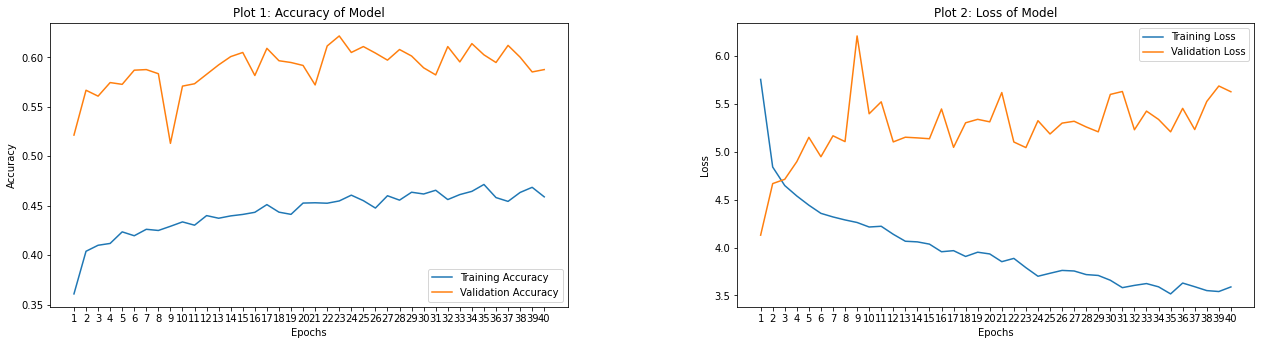

In [38]:
import numpy as np

train_accs = hist.history['accuracy']
test_accs = hist.history['val_accuracy']
train_loss = hist.history['loss']
test_loss = hist.history['val_loss']
epoch_range = [x + 1 for x in range(len(train_accs))]

fig, ax = plt.subplots(1, 2)
fig.tight_layout(pad=2)
fig.set_size_inches(20, 5)

plt.subplot(1, 2, 1)
plt.plot(np.asarray(epoch_range).astype(str), train_accs, label='Training Accuracy')
plt.plot(np.asarray(epoch_range).astype(str), test_accs, label='Validation Accuracy')
plt.title('Plot 1: Accuracy of Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(np.asarray(epoch_range).astype(str), train_loss, label='Training Loss')
plt.plot(np.asarray(epoch_range).astype(str), test_loss, label='Validation Loss')
plt.title('Plot 2: Loss of Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [39]:
model.evaluate(test_dataset)

53/53 [==============================] - 12s 37ms/step - loss: 5.0038 - accuracy: 0.6279


[5.0038347244262695, 0.6279481053352356]

[3 3 3 4 3 3 4 4 3 4 3 2 4 0 4 3 3 3 4 0 3 3 3 2 0 0 0 4 4 0 3 4]


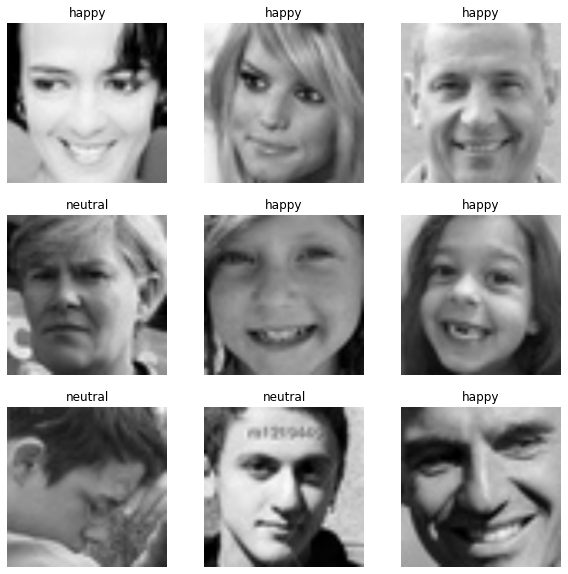

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

predictions = tf.nn.softmax(predictions)
predictions = np.argmax(predictions, axis=1)
print(predictions)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [48]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 0s 32ms/step


In [62]:
import sklearn.metrics
import scikitplot.metrics

print(sklearn.metrics.classification_report(correct_labels, predicted_labels))
print(class_names)

              precision    recall  f1-score   support

           0       0.48      0.42      0.44       284
           1       0.83      0.12      0.22        40
           2       0.58      0.44      0.50       259
           3       0.70      0.84      0.77       697
           4       0.58      0.58      0.58       416

    accuracy                           0.63      1696
   macro avg       0.63      0.48      0.50      1696
weighted avg       0.62      0.63      0.61      1696

['angry', 'disgust', 'fear', 'happy', 'neutral']


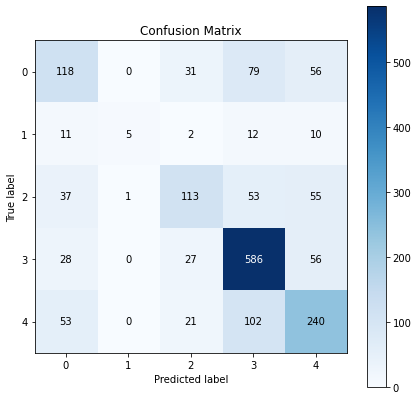

In [61]:
scikitplot.metrics.plot_confusion_matrix(correct_labels, predicted_labels, figsize=(7,7))